In [1]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten

In [39]:
# load VGG16 model without classification layers
model = VGG16(include_top=False, input_shape=(75, 75, 3))

In [40]:
# add new classification layers
flat1 = Flatten()(model.layers[-1].output) # flatten last layer
class1 = Dense(1024, activation='relu')(flat1) # add FC layer on previous layer
class1 = Dense(512, activation='relu')(flat1) # add FC layer on previous layer
output = Dense(6, activation='softmax')(class1) # add softmax layer

In [41]:
# define the new model
model = Model(inputs=model.inputs, outputs=output)

In [5]:
# necessary imports
import os
import cv2
import numpy as np
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from tqdm import tqdm

In [6]:
# A function to load data from a given directory
def load_data(data_dir):
  data = []
  labels = []
  class_dirs = os.listdir(data_dir)
  
  for direc in class_dirs:
    class_dir = os.path.join(data_dir, direc)
    for imagepath in tqdm(list(paths.list_images(class_dir))):
      image = cv2.imread(imagepath)
      image = cv2.resize(image, (75, 75))  # resizing for uniform size and colab crash issue
      data.append(image)
      labels.append(direc)
  # normalizing and converting to numpy array format
  data = np.array(data, dtype='float')/255.0
  labels = np.array(labels)
  return data, labels

In [7]:
train_dir = "/content/drive/MyDrive/Image-Classification-Dataset/seg_train/seg_train/"
test_dir = "/content/drive/MyDrive/Image-Classification-Dataset/seg_test/seg_test/"
pred_dir = "/content/drive/MyDrive/Image-Classification-Dataset/test/test/"

In [8]:
print('loading train images')
X_train, y_train = load_data(train_dir)

loading train images


100%|██████████| 2274/2274 [00:06<00:00, 333.96it/s]


In [9]:
print('loading validation images')
X_valid, y_valid = load_data(test_dir)

  8%|▊         | 34/437 [00:00<00:01, 335.65it/s]

loading validation images


100%|██████████| 501/501 [00:01<00:00, 325.32it/s]


In [10]:
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_valid = lb.fit_transform(y_valid)

In [42]:
from keras.optimizers import SGD
sgd = SGD(lr=0.001, decay=1e-7, momentum=.9)


model.compile(loss='categorical_crossentropy', 
              optimizer=sgd,
              metrics=['accuracy'])


In [43]:
#training without data augmentation
H = model.fit(X_train, y_train, batch_size=64,
              epochs=10, 
              validation_data=(X_valid, y_valid))

Epoch 1/10
220/220 [==============================] - 16s 71ms/step - loss: 0.7926 - accuracy: 0.7054 - val_loss: 0.3592 - val_accuracy: 0.8707
Epoch 2/10
220/220 [==============================] - 16s 71ms/step - loss: 0.2956 - accuracy: 0.8953 - val_loss: 0.2975 - val_accuracy: 0.8820
Epoch 3/10
220/220 [==============================] - 15s 69ms/step - loss: 0.2256 - accuracy: 0.9198 - val_loss: 0.2773 - val_accuracy: 0.8950
Epoch 4/10
220/220 [==============================] - 15s 69ms/step - loss: 0.1815 - accuracy: 0.9347 - val_loss: 0.2540 - val_accuracy: 0.9103
Epoch 5/10
220/220 [==============================] - 15s 69ms/step - loss: 0.1377 - accuracy: 0.9483 - val_loss: 0.2586 - val_accuracy: 0.9160
Epoch 6/10
220/220 [==============================] - 15s 70ms/step - loss: 0.1083 - accuracy: 0.9614 - val_loss: 0.2572 - val_accuracy: 0.9147
Epoch 7/10
220/220 [==============================] - 15s 70ms/step - loss: 0.0889 - accuracy: 0.9691 - val_loss: 0.2864 - val_accuracy:

In [31]:
#data augmentation
# from keras.preprocessing.image import ImageDataGenerator

# datagen = ImageDataGenerator(
#         rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
#         zoom_range = 0.1, # Randomly zoom image 
#         width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
#         height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
#         horizontal_flip=True,  # randomly flip images
#         vertical_flip=True)  # randomly flip images

# datagen.fit(X_train)

In [ ]:
#training with data augmentation
# HdAug = model.fit(datagen.flow(X_train, y_train, batch_size=64),
#               epochs=10, 
#               validation_data=(X_valid, y_valid))

In [17]:
print('loading test images')
x_test, y_test = load_data(pred_dir)

  0%|          | 0/1128 [00:00<?, ?it/s]

loading test images


100%|██████████| 1330/1330 [00:04<00:00, 325.82it/s]


In [18]:
y_test = lb.fit_transform(y_test)

In [44]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1, batch_size = 64)
loss_v, accuracy_v = model.evaluate(X_valid, y_valid, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
model.save("/content/dAug-model 128Bat.h5")

94/94 [==============================] - 1s 14ms/step - loss: 0.3174 - accuracy: 0.9140
Validation: accuracy = 0.914000  ;  loss_v = 0.317433
Test: accuracy = 0.895919  ;  loss = 0.482793


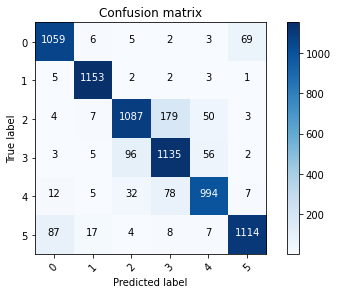

In [46]:
# Function to plot confusion matrix    
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(6)) 

Text(0, 0.5, 'Fraction classified incorrectly')

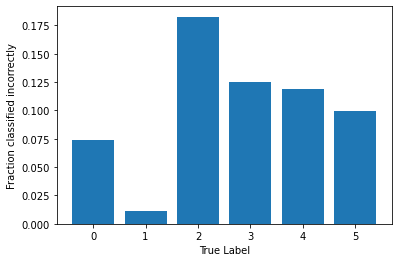

In [47]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(6),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')